Converts the user input file with 32 nodes to a TU input file with 10 nodes

In [1]:
import numpy as np 
import pandas as pd
import os, re, scienceplots
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from numba import njit
from time import perf_counter as pc
from scipy.interpolate import interp1d
from sklearn.decomposition import PCA
import tarfile

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

plt.style.use(["notebook", "science"])
plt.rcParams["figure.figsize"] = [15, 7]
plt.rcParams["figure.dpi"] = 150
plt.rcParams["lines.linewidth"] = 2

np.set_printoptions(linewidth=200)
np.set_printoptions(precision=3)

In [2]:
map_path = "raw txt-input 1416 samples 32 nodes/"
dir_list = os.listdir(map_path) # all the files
paths = [file for file in dir_list if file.endswith(".txt")] # filtering out files which is not txt

# a list with arrays 
dataset = [np.loadtxt(map_path + path) for path in paths]

In [3]:
def int_to_list(integer): # parameter must be between 0 and 9999
    """
    int_to_list(123) -> [0,1,2,3]
    int_to_list(3) -> [0,0,0,3]
    """
    result = [int(s) for s in str(integer)]  
    if integer > 999:
        return result
    if integer > 99:
        return [0] + result 
    if integer > 9:
        return [0,0] + result
    else:
        return [0,0,0,integer]

    
def header(*args, message="begin"):
    """
    header(1,2) -> "* data point #12 begin"
    header(0,0,3) -> "* data point #003 begin"
    header(1,3,4,5) -> "* data point #1345 begin"
    
    Should be used together with "int_to_list"
    header(*int_to_list(10), message="begin") -> "* data point #010 begin"
    """
    n_dict = len(args) * "{}"
    result = "* data point #" + n_dict + f" {message}"
    return result.format(*args)


@np.vectorize
def convert_E_to_D(number): 
    """
    Converts a number/array to another array with fortran compatible format as an array where the element is a string.
    
    convert_E_to_D(123) -> array('1.2300000000000D+02', dtype='<U19')
    convert_E_to_D([123, 456.7]) -> array(['1.2300000000000D+02', '4.5670000000000D+02'], dtype='<U19')
    
    To get a string representation just wrap str around the result.
    
    str(convert_E_to_D([123, 456.7])) -> "['1.2300000000000D+02' '4.5670000000000D+02']"
    """
    scientific_format = format(float(number), "0.13E")
    fortran_format = str(scientific_format).replace("E", "D") # replacing the E of the scientific notation to a D
    return fortran_format


def string_with_floats_to_array(sequence_str):
    """
    string_with_floats_to_array("1 2 3") -> array([1, 2, 3])
    """
    sequence = np.array([float(s) for s in sequence_str.split(" ") if s != ""]) 
    return sequence


def increase_spacing_opt(text, spacing=3, significant_digits=5):
    """
    text: string with floats separated by space with absolute value smaller than 1
    spacing: int
    significant_digits: integer larger or equal to 1
    
    Takes a string of space separated numbers and icrease the spacing between the numbers.
    Also padds the right side with zeros to make sure that all the numbers have the same number of characters.
    
    increase_spacing("0.1 0.24    0.369", spacing=3, significant_digits=5) -> "   0.10000   0.24000   0.36900"
    """
    lines = text.split("\n") # Split string by newline
    floats = [[float(x) for x in line.split()] for line in lines] # convert substrings to floats

    # Use a nested list comprehension to format the floats with a width of 9, and include trailing spaces
    string_format = "{:" + f"{significant_digits + 2 * spacing - 1}.{significant_digits}" + "f}"
    formatted_floats = [[string_format.format(x) for x in sublist] for sublist in floats]
    formatted_floats = ["".join(sublist) for sublist in formatted_floats] # Join the sublists
    final_string = "\n".join(formatted_floats) # Join the sublists with newline
    
    return final_string



@np.vectorize
def array_formatter(text, precision=5, fractional=True, unique=False):
    """
    Mapping a list with elements with inconsistent number of decimals
    to an array where every element is represented as a string 
    with "precision" number of significant digits.
    
    array_formatter([0.123456, 0.654321467]) -> array(['0.12346', '0.65432'], dtype='<U7')
    """
    return np.format_float_positional(text, precision=precision, unique=unique, fractional=fractional)

@njit ### IMPORTANT, this function makes the frist row print 8 items and the second row 2 items
def split_matrix(matrix, columns=8):
    first_list = matrix[:, :columns]
    second_list = matrix[:, columns:]
    return first_list, second_list

def array_to_table(profiles):
    """
    Turns an array of profiles to a list of rows representated as strings.
    This is a high level function taht should be used with array_formatter and increase_spacing.
    
    array_to_table([[0.1,0.2], [0.3,0.4]]) -> ['   0.10000   0.20000', '   0.30000   0.40000']
    """
    profiles = np.array(profiles)
    profile_chuncks = np.ceil(profiles.shape[-1] / 8).astype(int) # integer, usually have a value of 4
    partitions = np.array_split(profiles[None], profile_chuncks, axis=-1) # list of arrays
    partitions = np.concatenate(partitions, axis=0) 
    table = np.swapaxes(partitions, 0, 1) 

    table_str = array_formatter(table)
    table_float = table_str.astype(np.float64)
    table_float_mod = np.array2string(table_float).replace("[", "").replace("]", "")
    table_modified = increase_spacing_opt(table_float_mod)

    # table_mod but split up into chuncks
    table_modified_chuncks = table_modified.split("\n\n")
    return table_modified_chuncks


def array_to_table_truncated(profiles):
    profiles = np.array(profiles)
    row1, row2 = split_matrix(profiles)
    table1, table2 = array_formatter(row1).astype(float), array_formatter(row2).astype(float)
    
    table_float_mod1 = np.array2string(table1).replace("[", "").replace("]", "")
    table_float_mod2 = np.array2string(table2).replace("[", "").replace("]", "")
    
    table_modified1 = increase_spacing_opt(table_float_mod1)
    table_modified2 = increase_spacing_opt(table_float_mod2)
    
    Q_table1 = table_modified1.split("\n\n")[0].split("\n")
    Q_table2 = table_modified2.split("\n\n")[0].split("\n")
    
    return Q_table1, Q_table2


def save_to_TU(string, n, map_dir="input/TU_input_pow2_10nodes/"): ### NOTE
    with open(map_dir + "TU_" + f"{n}.txt", "w") as file:
        file.write(string)
    file.close()
    
separation_line = "*---+----+-------------------+-------------------+---------+---------------------\n"

def print_time(t, complete_file):
    # for visual purporses
    complete_file += separation_line + "*   1: printout of the result at time [hours]\n" + separation_line
    complete_file += t + "\n"
    complete_file += separation_line
    return complete_file


def program_termination(t, complete_file):
    complete_file += "*  00:  last line of data set (finishing the program)\n"
    complete_file += separation_line + "00000    0" + t + "\n"
    complete_file += separation_line
    return complete_file


h = lambda n: (np.arange(n) + 1/2)/n
h10 = h(10)
h32 = h(32)

In [12]:
def ph_to_TU(data, n, save=True):
    t = data[...,0]
    Q = data[...,6:]
    Q_int = interp1d(h32, Q)    
    Q = Q_int(h10)
    P = data[...,2:3].mean() # this is alsmost always constant
    FASTF = data[...,1:2]
    T = data[...,3:4].flatten()
    
    Q_mean = Q.mean(-1, keepdims=True)
    Q_profiles = Q / Q_mean
    
    flux = Q * FASTF / 10 # n/(cm^2 s)
    flux_mean = flux.mean(-1, keepdims=True)
    flux_profiles = Q_profiles * FASTF / FASTF.mean(1, keepdims=True)
    

    complete_file = ""

    # doing a vectorized operation before the loop to save some time
    t_fortran = convert_E_to_D(t)
    Q_mean_fortran = convert_E_to_D(Q_mean[:,0])
    flux_mean_fortran = convert_E_to_D(flux_mean[:,0])

    Q_table = array_to_table(Q_profiles)
    flux_table = array_to_table(flux_profiles)

    # adding the staring line
    complete_file += header(*int_to_list(n+1), message="begin") + "\n*\n"

    for i in range(len(t)):
        heat_headline = "{:5d}{:5d} {} {}\n".format(2, 1, t_fortran[i], Q_mean_fortran[i])
        flux_headline = "{:5d}{:5d} {} {}\n".format(3, 1, t_fortran[i], flux_mean_fortran[i])
        temperature_headline = "{:5d}{:5d} {} {}\n".format(9, 0, t_fortran[i], convert_E_to_D(T[i]))
        pressure_headline = "{:5d}{:5d} {} {}\n".format(10, 0, t_fortran[i], convert_E_to_D(P.mean()))
        time_attribute = "{:5d}{:5d} {}".format(1, 0, t_fortran[i])
        
        # printing out the time (visual purporse)
        complete_file = print_time(time_attribute, complete_file)
        complete_file += heat_headline + Q_table[i] + "\n" \
                       + flux_headline + flux_table[i] + "\n" \
                       + temperature_headline \
                       + pressure_headline
    

    complete_file += header(*int_to_list(n+1), message="end") + "\n"
    complete_file = program_termination(f" {t_fortran[i]}", complete_file)
    print(complete_file)
    
    if save:
        save_to_TU(complete_file, n)
            
            
#for n in tqdm(range(len(dataset))): 
for n in range(1): 
    ph_to_TU(dataset[n], n, save=False)

* data point #0001 begin
*
*---+----+-------------------+-------------------+---------+---------------------
*   1: printout of the result at time [hours]
*---+----+-------------------+-------------------+---------+---------------------
    1    0 0.0000000000000D+00
*---+----+-------------------+-------------------+---------+---------------------
    2    1 0.0000000000000D+00 3.4328200000000D+01
   0.64100   0.82800   0.92600   1.00600   1.07400
   1.12800   1.16700   1.18900   1.17200   0.86900
    3    1 0.0000000000000D+00 1.2107556140000D+13
   0.64100   0.82800   0.92600   1.00600   1.07400
   1.12800   1.16700   1.18900   1.17200   0.86900
    9    0 0.0000000000000D+00 2.9150000000000D+02
   10    0 0.0000000000000D+00 1.5693750000000D+01
*---+----+-------------------+-------------------+---------+---------------------
*   1: printout of the result at time [hours]
*---+----+-------------------+-------------------+---------+---------------------
    1    0 1.4400000000000D+02
*

(Text(0.5, 0, 'Q'), Text(0, 0.5, 'h'))

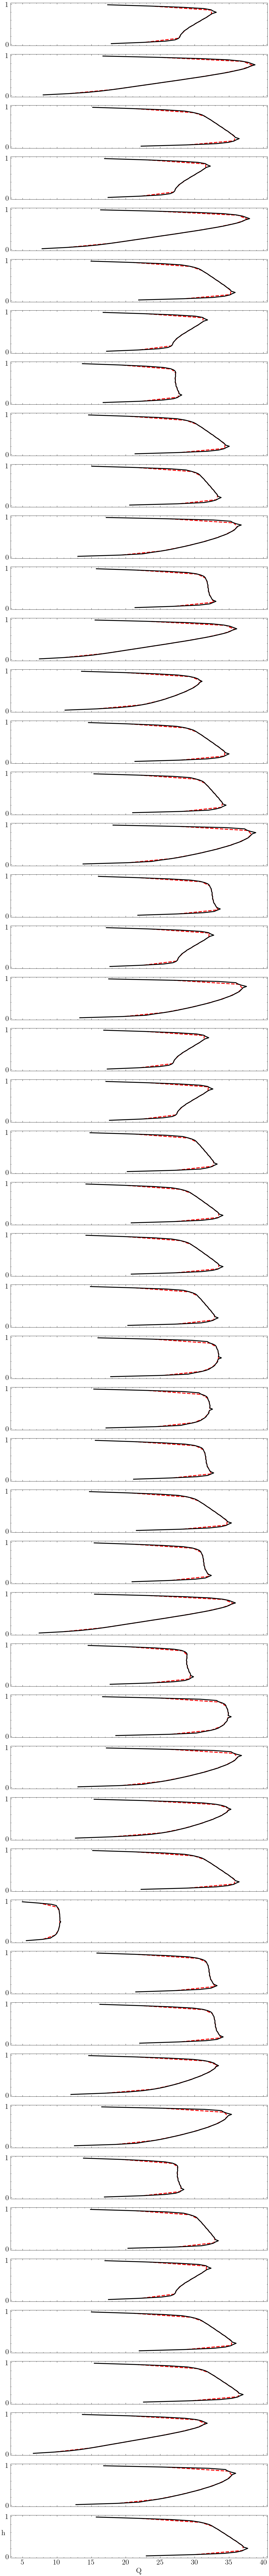

In [114]:
fig, ax = plt.subplots(50, 1, sharey=True, sharex=True, figsize=[10, 100])

for j in range(50):
    """
    Kontroll: plottar de 50 första falllen med Q som innehåller 6 stegen
    """
    Q = data16[...,6:][j]

    h = lambda n: (np.arange(n) + 1/2)/n
    h10 = h(10)
    h32 = h(32)
    Q_int = interp1d(h32, Q)
    
    # for i in range(10):
    i = np.random.randint(0, 9)
    ax[j].plot(Q_int(h10)[i], h10, "r--")
    ax[j].plot(Q[i], h32, "k")

ax[j].set_xlabel("Q"), ax[j].set_ylabel("h", rotation=0)

(Text(0.5, 0, 'Q'), Text(0, 0.5, 'h'))

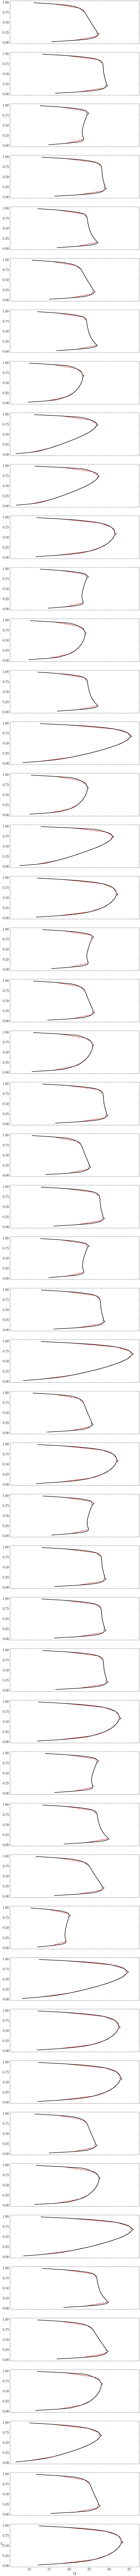

In [117]:
fig, ax = plt.subplots(50, 1, sharey=True, sharex=True, figsize=[10, 200])

for j in range(50):
    """
    Kontroll: plottar de 50 första falllen med Q som innehåller 25 stegen
    """
    Q = data25[...,6:][j]

    h = lambda n: (np.arange(n) + 1/2)/n
    h10 = h(10)
    h32 = h(32)
    Q_int = interp1d(h32, Q)
    
    # for i in range(10):
    i = np.random.randint(0, 9)
    ax[j].plot(Q_int(h10)[i], h10, "r--")
    ax[j].plot(Q[i], h32, "k")

ax[j].set_xlabel("Q"), ax[j].set_ylabel("h", rotation=0)